# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from operator import itemgetter
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


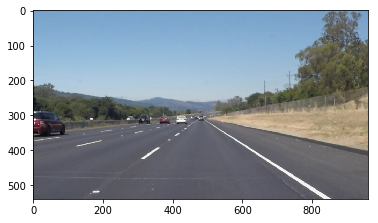

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [49]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image                

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, filtering=1, output=0):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)        
    draw_lines(line_img, lines, filtering)
    if (output == 1):
        line_img_raw = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)        
        draw_raw_lines(line_img_raw, lines)
    return line_img

def draw_raw_lines(img, lines, color=[255, 0, 0], thickness=1):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    mpimg.imsave(output_folder+"hough_2.jpg", img)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    if (initial_img.shape[2] == 4):
        initial_img = initial_img[:,:,0:3] 
    assert(initial_img.shape == img.shape)
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Global Variable
I decide to use global variables for the coordinates of the 2 lines. By having this information available at each iteration, it enables me to do some filtering and discard the wrong detections.

In [42]:
global_left_x1 = 0
global_left_y1 = 0
global_left_x2 = 0
global_left_y2 = 0

global_right_x1 = 0
global_right_y1 = 0
global_right_x2 = 0
global_right_y2 = 0

def initialize_global_var():
    global global_left_x1 
    global global_left_y1 
    global global_left_x2 
    global global_left_y2 
    global global_right_x1
    global global_right_y1
    global global_right_x2
    global global_right_y2
    
    global_left_x1 =0
    global_left_y1 =0
    global_left_x2 =0
    global_left_y2 =0
    global_right_x1 =0
    global_right_y1 =0
    global_right_x2 =0
    global_right_y2 =0

### Draw Lines Function

The output I first obtained was flickering a lot. I wasn't doing any averaging of the lines.
My first idea was to average every x1, y1, x2, y2 for both lines, one labelled left and the other right. The problem is that for each image I was receiving about 10 lines. Some were much smaller than the others. Th basic average on that shifted the result way off. 

I thought I would keep the highest (x, y) position (lowest in x) in for the bottom corners and average the top corner of the trapeze over the 3 highest positions in y (highest . In my view, x1 and y1 are the bottom corners.


                   ______   <- (right_x2, right_y2)
                  /      \      
                 /        \
                /          \
               /            \
              /              \
             /                \
            /__________________\    <- (right_x1, right_y1)
            
            
Extrapolating consists of continuing the line obtained to make up for the fact that some lines are doted. 
I compute the line coefficient are deduce the x position (bottom of the screen) at y being equal to the height of the image. 



In [43]:
from itertools import islice

def draw_lines(img, lines, filtering=1, color=[255, 0, 0], thickness=15):
    global global_left_x1 
    global global_left_y1 
    global global_left_x2 
    global global_left_y2 
    global global_right_x1
    global global_right_y1
    global global_right_x2
    global global_right_y2
    width = image.shape[1]
    height = image.shape[0]
    left_count = 0
    right_count = 0
    left_x1 = 0
    left_y1 = 0
    left_x2 = 0
    left_y2 = 0
    left_horizon = []
    right_horizon = []
    right_x1 = 0
    right_y1 = 0
    right_x2 = 0
    right_y2 = 0
    
    try:  
        # Averaging
        for line in lines:
            for x1,y1,x2,y2 in line:
                if abs(y1-y2) < 10:
                        continue
                a = ((y2-y1)/(x2-x1))
                if (a < 0):
                    if (y1 > y2):
                        if ((y1 > left_y1) & (x1 < (width/2))):
                            left_y1 = y1
                            left_x1 = x1
                        left_horizon.append((x2, y2))
                    else:
                        if ((y2 > left_y1) & (x2 < (width/2))):
                            left_y1 = y2
                            left_x1 = x2
                        left_horizon.append((x1, y1))
                else:
                    if (y1 > y2):
                        if ((y1 > right_y1) & (x1 > (width/2))):
                            right_y1 = y1
                            right_x1 = x1
                        right_horizon.append((x2, y2))
                    else:
                        if ((y2 > right_y1) & (x2 > (width/2))):
                            right_y1 = y2
                            right_x1 = x2
                        right_horizon.append((x1, y1))

        left_sorted_horizon = sorted(left_horizon, key=itemgetter(1), reverse=False)   # Sorted by y position
        right_sorted_horizon = sorted(right_horizon, key=itemgetter(1))
        
        nb_avg_pos_left = min(3, len(left_sorted_horizon))
        for pos in islice(left_sorted_horizon, nb_avg_pos_left):
            left_x2 = left_x2 + pos[0] #x
            left_y2 = left_y2 + pos[1] #y 
        nb_avg_pos_right = min(3, len(right_sorted_horizon))
        for pos in islice(right_sorted_horizon, nb_avg_pos_right):
            right_x2 = right_x2 + pos[0] #x
            right_y2 = right_y2 + pos[1] #y

        left_x2 = left_x2 / nb_avg_pos_left
        left_y2 = left_y2 / nb_avg_pos_left
        right_x2 = right_x2 / nb_avg_pos_right
        right_y2 = right_y2 / nb_avg_pos_right

        # y = ax + b
        if (left_x2 != left_x1):
            left_a = ((left_y2-left_y1)/(left_x2-left_x1))
        else:
            left_a = ((left_y2-left_y1)/(left_x2-left_x1+0.00001))

        right_a = ((right_y2-right_y1)/(right_x2-right_x1))
        left_b = left_y1 - left_x1 * left_a
        right_b = right_y1 - right_x1 * right_a

        # Extrapolating
        if math.isclose(height, left_b, rel_tol=1e-5):
            left_x1 = 0 
        else:
            left_x1 = (height - left_b)/float(left_a)
            left_x1 = int(min(left_x1, width))
        if math.isclose(height, right_b, rel_tol=1e-5):
            right_x1 = 0 
        else:
            right_x1 = (height - right_b)/float(right_a)
            right_x1 = int(min(right_x1, width))    

        # Filtering
        if (filtering != 1):
            coeff_of_new = filtering
            if (global_right_x1 == 0): # If it is the first time, no low pass filter
                global_left_x1 = left_x1
                global_left_y1 = height
                global_left_x2 = left_x2
                global_left_y2 = left_y2
                global_right_x1 = right_x1
                global_right_y1 = height
                global_right_x2 = right_x2
                global_right_y2 = right_y2
            else:
                global_left_x1 = left_x1 * coeff_of_new + (1 - coeff_of_new) *global_left_x1
                #global_left_y1 = left_y1 * coeff_of_new + (1 - coeff_of_new) *global_left_y1
                global_left_x2 = left_x2 * coeff_of_new + (1 - coeff_of_new) *global_left_x2
                global_left_y2 = left_y2 * coeff_of_new + (1 - coeff_of_new) *global_left_y2
                global_right_x1 = right_x1 * coeff_of_new + (1 - coeff_of_new) *global_right_x1
                #global_right_y1 = right_y1 * coeff_of_new + (1 - coeff_of_new) *global_right_y1
                global_right_x2 = right_x2 * coeff_of_new + (1 - coeff_of_new) *global_right_x2
                global_right_y2 = right_y2 * coeff_of_new + (1 - coeff_of_new) *global_right_y2
            cv2.line(img, (int(global_left_x1), int(global_left_y1)), (int(global_left_x2), int(global_left_y2)), color, thickness)
            cv2.line(img, (int(global_right_x1), int(global_right_y1)), (int(global_right_x2), int(global_right_y2)), color, thickness)
        else:
            # No filtering
            cv2.line(img, (int(left_x1), height), (int(left_x2), int(left_y2)), color, 15)
            cv2.line(img, (int(right_x1),height), (int(right_x2),int(right_y2)), color, 15)
    except:
        # if division by 0 -> print last detected lines
        if (filtering != 1):
            cv2.line(img, (int(global_left_x1), int(global_left_y1)), (int(global_left_x2), int(global_left_y2)), color, thickness)
            cv2.line(img, (int(global_right_x1), int(global_right_y1)), (int(global_right_x2), int(global_right_y2)), color, thickness)
            

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [44]:
import os
dir = os.listdir("test_images/")
for file in dir:
    print(file)

.DS_Store
solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


## Build a Lane Finding Pipeline



Here is my first pipeline. It worked fine on the "easy" videos but couldn't make the trick on the 'challenge.mp4'.

In [45]:
def process_image(image, kernel_size, low_th, high_th, vertices, threshold, min_line_len, max_line_gap, filtering=1):
    gray_image = grayscale(image)
    blur_image = gaussian_blur(gray_image, kernel_size)
    canny_image = canny(blur_image, low_th, high_th)
    masked_image = region_of_interest(canny_image, vertices)
    hough_image = hough_lines(masked_image, 1, np.pi/180, threshold, min_line_len, max_line_gap, filtering)
    weighted_image = weighted_img(hough_image, image, 0.9, 0.9)
    return weighted_image

### Pipeline understanding
For the sake of understanding what is each step of the pipeline doing. I have slightly modified my process_image() function to save and display each sub-functions result. 

In [51]:
output_folder = "test_image_output/"

def process_image_save_images(image, kernel_size, low_th, high_th, vertices, threshold, min_line_len, max_line_gap, filtering=1):
    gray_image = grayscale(image)
    mpimg.imsave(output_folder+"gray.jpg", gray_image, cmap='gray')
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow_image = cv2.inRange(hsv, (15, 80, 80), (35, 255, 255))
    mpimg.imsave(output_folder+"yellow.jpg", yellow_image, cmap='gray')
    white_image = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    mpimg.imsave(output_folder+"white.jpg", white_image, cmap='gray')
    gray = cv2.bitwise_or(yellow_image, white_image)
    #gray = cv2.bitwise_or(gray, gray_image)
    blur_image = gaussian_blur(gray, kernel_size)
    mpimg.imsave(output_folder+"blur.jpg", blur_image, cmap='gray')
    canny_image = canny(blur_image, low_th, high_th)
    mpimg.imsave(output_folder+"canny.jpg", canny_image)
    masked_image = region_of_interest(canny_image, vertices)
    mpimg.imsave(output_folder+"mask.jpg", masked_image)
    hough_image = hough_lines(masked_image, 1, np.pi/180, threshold, min_line_len, max_line_gap, filtering, 1)
    mpimg.imsave(output_folder+"hough.jpg", hough_image)
    weighted_image = weighted_img(hough_image, image, 0.9, 0.9)
    return weighted_image

Here a piece of code to call it on the "solidWhiteCurve.jpg" image.

I've run a lot of experiment to tune the range of detection for the yellow image. 

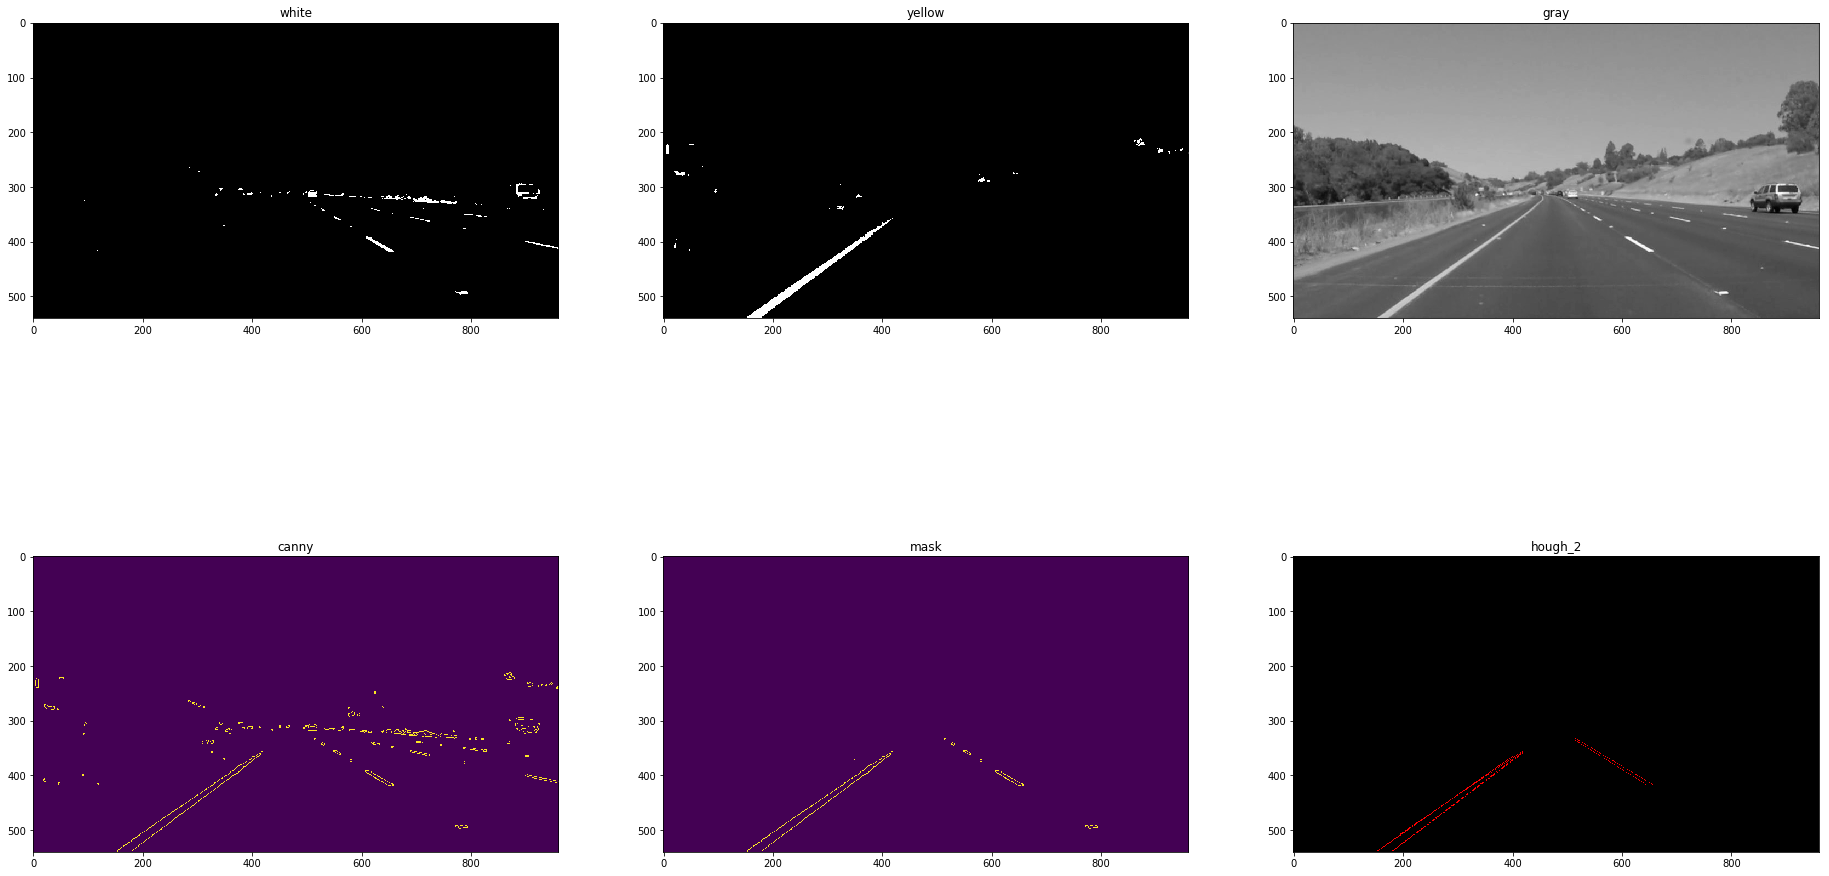

In [52]:
def showimg(subplace, title, _img):
    plt.subplot(*subplace)
    plt.axis('off')
    plt.title(title)
    plt.imshow(_img)

def show_pipeline(image):
    plt.figure(figsize=[32, 18])
    height = image.shape[0]
    width  = image.shape[1]
    vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
    processed_image = process_image_save_images(image, 5, 60, 170, vertices, 30, 1, 100)
    i = 1
    for file in ['white', 'yellow', 'gray', 'canny', 'mask', 'hough_2']:
        image = mpimg.imread(output_folder+str(file)+'.jpg')
        showimg((2, 3, i), str(file), image)
        i = i + 1 

image = mpimg.imread('test_images/solidYellowCurve.jpg')   
show_pipeline(image)

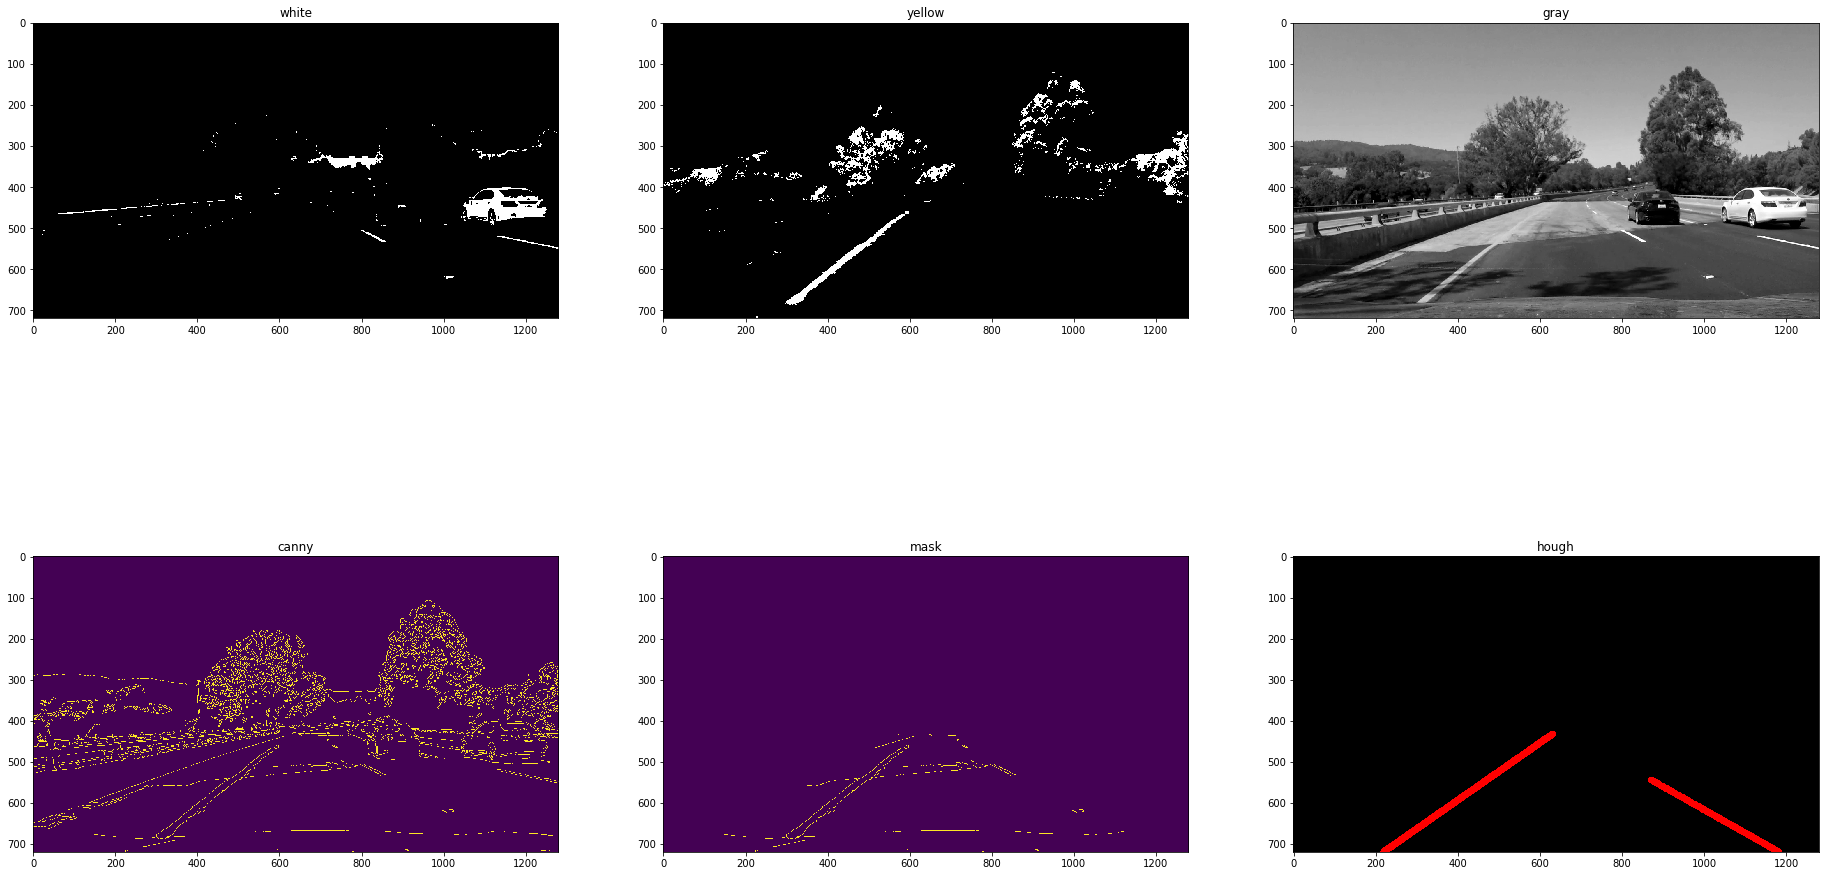

In [16]:
image = mpimg.imread('test_images_challenge/150.jpg')
show_pipeline(image)

## Final pipeline after experimentation and improvements


In [60]:
def process_image(image, kernel_size, low_th, high_th, vertices, threshold, min_line_len, max_line_gap, filtering=1, use_grey=True):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow_image = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    white_image = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray_image = cv2.bitwise_or(yellow_image, white_image)
    if (use_grey):
        gray = grayscale(image)
        gray_image = cv2.bitwise_or(gray, gray_image)
    blur_image = gaussian_blur(gray_image, kernel_size)
    canny_image = canny(blur_image, low_th, high_th)
    masked_image = region_of_interest(canny_image, vertices)
    hough_image = hough_lines(masked_image, 1, np.pi/180, threshold, min_line_len, max_line_gap, filtering)
    weighted_image = weighted_img(hough_image, image, 0.9, 0.9)
    return weighted_image

## Images Testing results
I am reusing the showing() function from the last cell but I'm not showing each intermediate output now that we've understood the concept. 

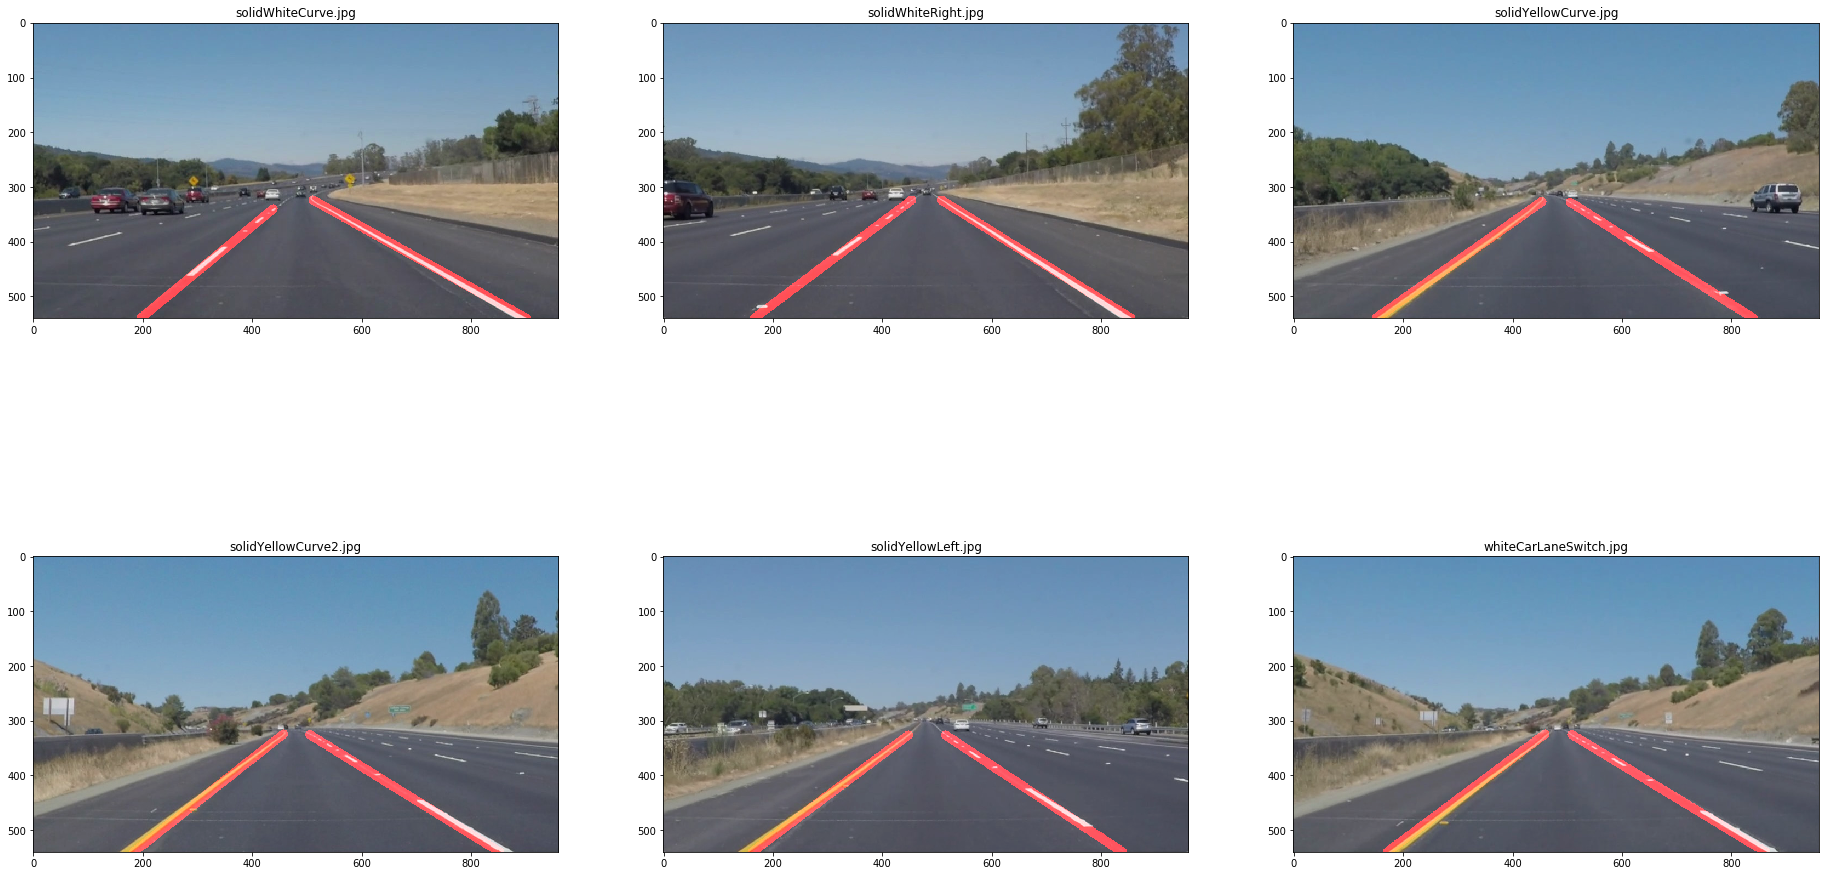

In [59]:
plt.figure(figsize=[32, 18])
output_folder = "test_image_output/"
i = 1
for file in dir:
    if (file != ".DS_Store"):
        image = mpimg.imread('test_images/'+file)
        height = image.shape[0]
        width  = image.shape[1]
        vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
        processed_image = process_image(image, 5, 60, 170, vertices, 30, 1, 100)
        mpimg.imsave(output_folder+file, processed_image)
        showimg((2, 3, i), file, processed_image)
        i = i + 1                  

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [64]:
def process_image_caller(image):
    height = image.shape[0]
    width  = image.shape[1]
    vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
    result = process_image(image, 5, 60, 170, vertices, 30, 1, 100, 0.05)
    return result

## Export images form the videos
In order to have more images, I saved several images out of the 3 videos provided with the following function.

In [65]:
interval = 50
counter = 0
output_folder = "test_images_challenge/"
index = 0

def save_images(image):
    global index
    global counter
    if (counter == 0):
        index = index + 1
        mpimg.imsave(output_folder+str(index*interval)+".jpg", image)
        counter = 50
    else:
        counter = counter - 1
    return image

In [66]:
dir = os.listdir("test_videos")
output_folder = "test_videos_output/"
for file in dir:
    if ((file != ".DS_Store") & (file != "challenge.mp4")):
        print(file)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
        initialize_global_var()
        clip1 = VideoFileClip("test_videos/"+file)
        white_clip = clip1.fl_image(process_image_caller)                   #NOTE: this function expects color images!!
        %time white_clip.write_videofile(output_folder+file, audio=False)

solidWhiteRight.mp4
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:10<00:00, 20.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.81 s, sys: 390 ms, total: 6.2 s
Wall time: 12.1 s
solidYellowLeft.mp4
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:40<00:00, 15.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 20.2 s, sys: 1.38 s, total: 21.5 s
Wall time: 42.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [102]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidWhiteRight.mp4"))

In [103]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidYellowLeft.mp4"))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## Pipeline results on snapshots from the challenge.mp4 video

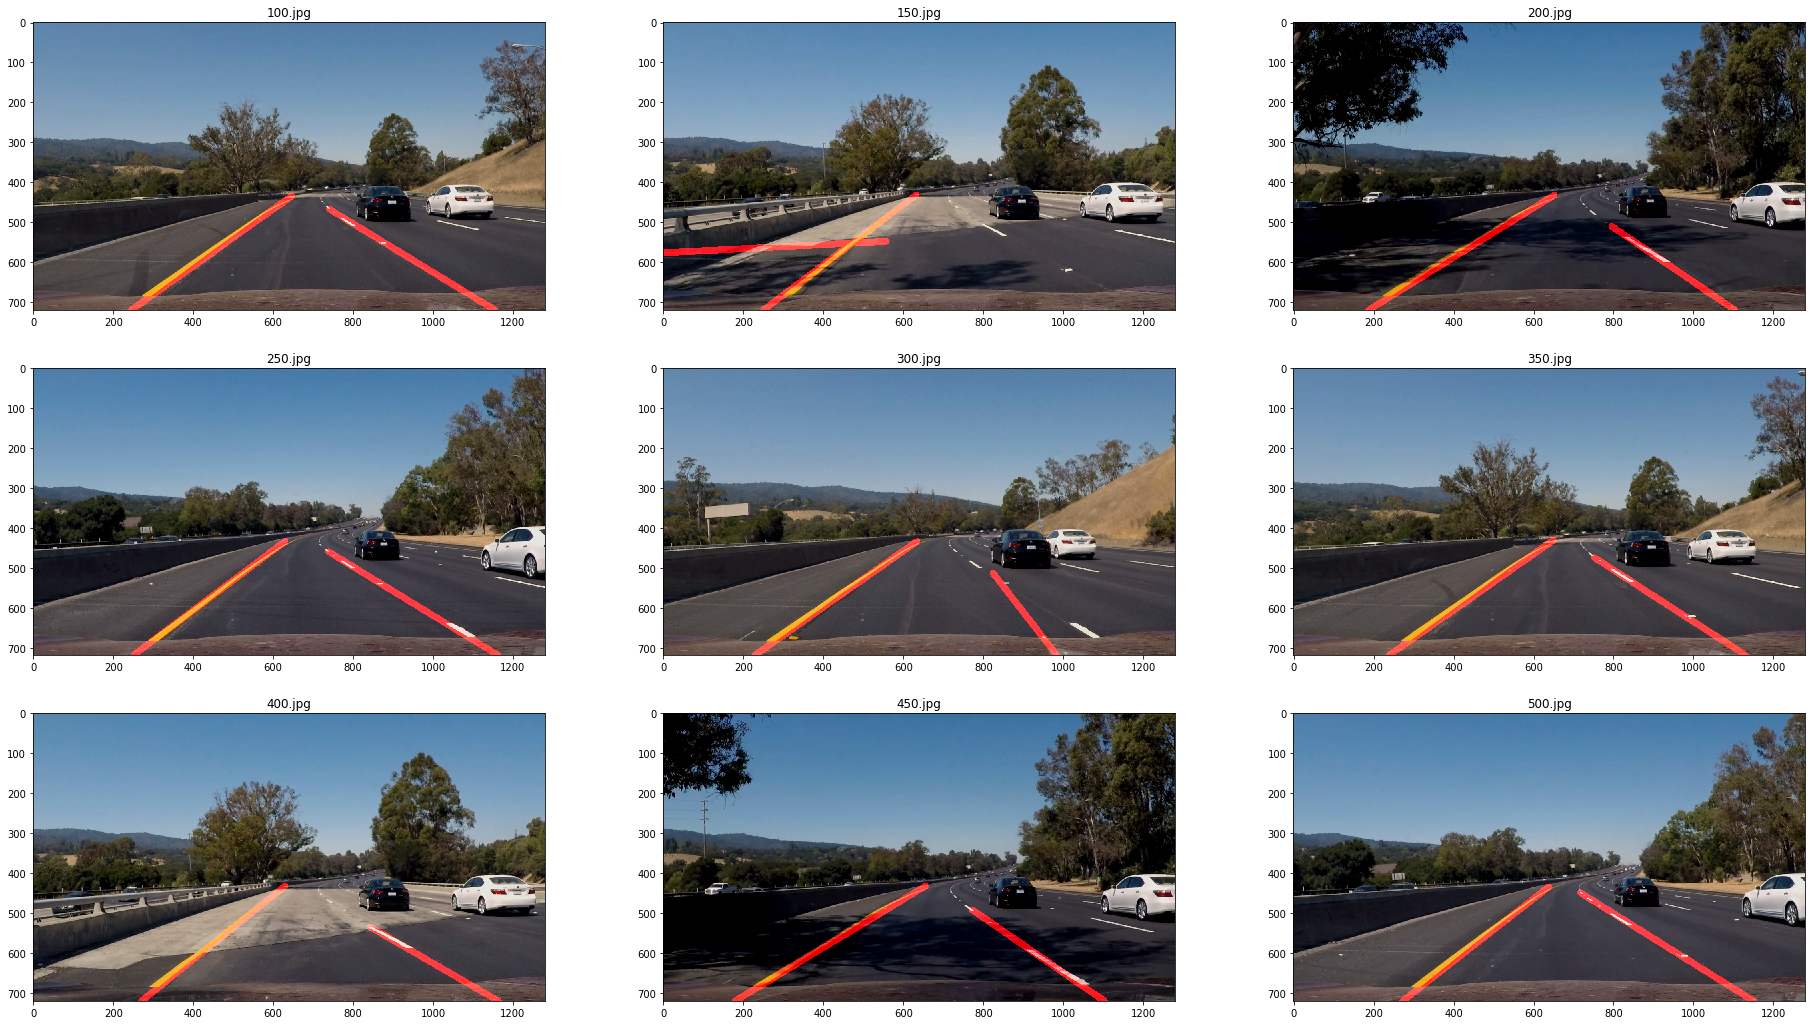

In [67]:
plt.figure(figsize=[32, 18])
i = 1
dir = os.listdir("test_images_challenge/")
output_dir = "test_image_output/"
for file in dir:
    if file != ".DS_Store":
        image = mpimg.imread('test_images_challenge/'+file)
        height = image.shape[0]
        width  = image.shape[1]
        vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
        processed_image = process_image(image, 5, 60, 170, vertices, 30, 1, 100, 1)
        mpimg.imsave(output_dir+file, processed_image)
        showimg((3, 3, i), file, processed_image)
        i = i + 1       

In [68]:
def process_image_caller(image):
    height = image.shape[0]
    width  = image.shape[1]
    vertices=np.array([[(50,height),(width*0.45,height*0.6),(width*0.55,height*0.6),(width-50,height)]], dtype=np.int32)
    result = process_image(image, 5, 60, 170, vertices, 30, 1, 100, 0.05, use_grey=False)
    return result

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
initialize_global_var()
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_caller)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:25<00:00,  9.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9.42 s, sys: 650 ms, total: 10.1 s
Wall time: 28.3 s


In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/challenge.mp4"))